In [1]:
import numpy as np
import csv

In [2]:
labels = []

with open("images/faceLabels.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(row)
labels = np.array(labels[1:])
len(labels)

1999

In [3]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
#if true, re-reads and saves all images to numpy array
if False:
    images = []
    size = (128,128)
    print("reading in images...")
    for line in tqdm(labels):
        ##read and convert to Black and White

        img = io.imread('images/'+line[0], as_grey=True)
        img = resize(img, size)
        images.append(img)
    print("saving...")
    
    npimages = np.zeros(shape=(len(images),*size), dtype=np.float64)
    for i,im in enumerate(images):
        npimages[i] = im
    labels = np.array(labels[:,1],dtype=str)
    print(labels)
    np.save("data/labels.npy",labels)
    np.save("data/images.npy",npimages)
    print("SAVED")
    

In [5]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")
print(images.dtype)
print(labels.dtype)

float64
<U12


		Happy


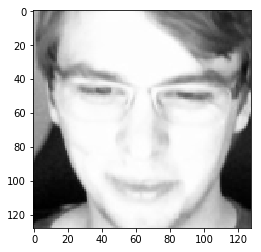

In [6]:
idx = np.random.randint(0,len(labels))
plt.imshow(images[idx], cmap="gray")
print("\t\t"+str(labels[idx]))

In [7]:
import random
def balanced_subset(images,labels):
    #np.warnings.filterwarnings('ignore')
    count = Counter(labels)
    perclass_count = np.array([[c,count[c]] for c in count.keys()])
    max_n = min(perclass_count[:,1])
    
    perclass_indexes = {cname:random.sample(range(0, n), max_n) for cname,n in perclass_count}
    perclass_index = {label:0 for label in count.keys()}
    
    newlabels = []
    newimages = []
    total = 0
    for i in range(len(labels)):
        
        label = labels[i]

        if perclass_index[label] in perclass_indexes[label]:
            total += 1
            newlabels.append(label)
            newimages.append(images[i])
        perclass_index[label] += 1
            
    newimages, newlabels = np.array(newimages),np.array(newlabels)   
        
    #print(perclass_count,perclass_indexes)
    return newimages, newlabels

In [8]:
from collections import Counter
labels = [x.lower() for x in labels]
count = Counter(labels)
#print(c.most_common())
label2int = {y:x for x,(y,_) in enumerate(count.most_common())}
int2label = {label2int[key]:key for key in label2int.keys()}

nplabels = np.array([label2int[x] for x in labels])
assert(len(nplabels) == len(images))
print("count:",count.most_common(),"\n")

count: [('happy', 500), ('sad', 500), ('angry', 500), ('neutral', 499)] 



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(images, nplabels, test_size=.1)
len(y_val)

200

In [10]:
def next_batch(images, labels, batch_size):
    images, labels = shuffle(images,labels)
    for i in range(0,len(labels),batch_size):
        if i+batch_size >= len(labels):
            yield images[i:],labels[i:]
        else:
            yield images[i:i+batch_size],labels[i:i+batch_size]

In [11]:
print(images[0].shape)

(128, 128)


# Build Model

In [12]:
import tensorflow as tf
from Expression_Network import Expression_Network

In [13]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float32, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.int32, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")
one_hot = tf.one_hot(y,num_classes)
reshaped = tf.expand_dims(x,-1)

exnet = Expression_Network(num_classes,Training=True)
logits,prediction = exnet.model(x)

In [14]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot)
loss_op = tf.reduce_mean(cross_entropy)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss_op)
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [15]:
epochs = 150
learn_rate = .0001
batch_size = 64

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(epochs):
        batch_i = 1
        
        for x_batch,y_batch in next_batch(x_train,y_train,batch_size):
            sess.run(optimizer,feed_dict={x:x_batch,y:y_batch,lr:learn_rate,exnet.train_pl:True})
        
            if batch_i % 10 == 0:
            
                valacc = sess.run(accuracy,feed_dict={x:x_val,y:y_val,exnet.train_pl:False})
                loss, trainacc = sess.run([loss_op, accuracy], feed_dict={x:x_train,y:y_train,exnet.train_pl:False})
                print("epoch:{} batch:{}\ttrain accuracy: {}\tloss: {}\tval acc: {}"
                 .format(epoch,batch_i,round(float(trainacc),4),round(float(loss),4), round(float(valacc),4)))
                
                
            batch_i += 1
    X,Y = balanced_subset(images,nplabels)
    X,Y = shuffle(X,Y)
    #print(sess.run(prediction,feed_dict={x:X,y:Y}))
    
  
    save_path = saver.save(sess, "checkpoints/model.ckpt")

            

epoch:0 batch:10	train accuracy: 0.2785	loss: 28.6575	val acc: 0.2
epoch:0 batch:20	train accuracy: 0.2674	loss: 21.3088	val acc: 0.19
epoch:1 batch:10	train accuracy: 0.284	loss: 13.3978	val acc: 0.21
epoch:1 batch:20	train accuracy: 0.2863	loss: 15.364	val acc: 0.21
epoch:2 batch:10	train accuracy: 0.2852	loss: 12.7984	val acc: 0.21
epoch:2 batch:20	train accuracy: 0.3074	loss: 10.5432	val acc: 0.225
epoch:3 batch:10	train accuracy: 0.3424	loss: 7.7231	val acc: 0.265
epoch:3 batch:20	train accuracy: 0.4458	loss: 4.6556	val acc: 0.38
epoch:4 batch:10	train accuracy: 0.3063	loss: 7.6347	val acc: 0.22
epoch:4 batch:20	train accuracy: 0.3758	loss: 4.911	val acc: 0.28
epoch:5 batch:10	train accuracy: 0.4814	loss: 3.3026	val acc: 0.43
epoch:5 batch:20	train accuracy: 0.4514	loss: 4.0778	val acc: 0.385
epoch:6 batch:10	train accuracy: 0.5092	loss: 2.7622	val acc: 0.46
epoch:6 batch:20	train accuracy: 0.4525	loss: 4.1747	val acc: 0.385
epoch:7 batch:10	train accuracy: 0.5442	loss: 2.8443	val

epoch:60 batch:10	train accuracy: 0.9844	loss: 0.059	val acc: 0.96
epoch:60 batch:20	train accuracy: 0.9878	loss: 0.0583	val acc: 0.965
epoch:61 batch:10	train accuracy: 0.9883	loss: 0.0568	val acc: 0.965
epoch:61 batch:20	train accuracy: 0.9861	loss: 0.058	val acc: 0.965
epoch:62 batch:10	train accuracy: 0.9906	loss: 0.0502	val acc: 0.965
epoch:62 batch:20	train accuracy: 0.9906	loss: 0.0494	val acc: 0.965
epoch:63 batch:10	train accuracy: 0.99	loss: 0.0501	val acc: 0.965
epoch:63 batch:20	train accuracy: 0.9894	loss: 0.0503	val acc: 0.97
epoch:64 batch:10	train accuracy: 0.9828	loss: 0.0582	val acc: 0.965
epoch:64 batch:20	train accuracy: 0.9889	loss: 0.0466	val acc: 0.965
epoch:65 batch:10	train accuracy: 0.9867	loss: 0.0519	val acc: 0.97
epoch:65 batch:20	train accuracy: 0.9883	loss: 0.0487	val acc: 0.975
epoch:66 batch:10	train accuracy: 0.9883	loss: 0.0499	val acc: 0.965
epoch:66 batch:20	train accuracy: 0.99	loss: 0.0467	val acc: 0.965
epoch:67 batch:10	train accuracy: 0.9889	lo

epoch:120 batch:10	train accuracy: 1.0	loss: 0.0068	val acc: 0.975
epoch:120 batch:20	train accuracy: 1.0	loss: 0.0068	val acc: 0.975
epoch:121 batch:10	train accuracy: 1.0	loss: 0.0073	val acc: 0.975
epoch:121 batch:20	train accuracy: 1.0	loss: 0.0071	val acc: 0.975
epoch:122 batch:10	train accuracy: 1.0	loss: 0.0067	val acc: 0.975
epoch:122 batch:20	train accuracy: 1.0	loss: 0.0066	val acc: 0.975
epoch:123 batch:10	train accuracy: 1.0	loss: 0.0061	val acc: 0.975
epoch:123 batch:20	train accuracy: 1.0	loss: 0.006	val acc: 0.975
epoch:124 batch:10	train accuracy: 1.0	loss: 0.0058	val acc: 0.975
epoch:124 batch:20	train accuracy: 1.0	loss: 0.0057	val acc: 0.975
epoch:125 batch:10	train accuracy: 1.0	loss: 0.0057	val acc: 0.975
epoch:125 batch:20	train accuracy: 1.0	loss: 0.0056	val acc: 0.975
epoch:126 batch:10	train accuracy: 1.0	loss: 0.0057	val acc: 0.975
epoch:126 batch:20	train accuracy: 1.0	loss: 0.0057	val acc: 0.975
epoch:127 batch:10	train accuracy: 1.0	loss: 0.0055	val acc: 0.

In [31]:
batch_i = np.array(0)
trainacc = np.array(0.238473172372)
loss = np.array(12314.52365646352)

In [34]:
print("batch: {}\ttrain accuracy: {}\tloss: {}"
                      .format(batch_i,np.round(trainacc,4),np.round(loss,4)))

batch: 0	train accuracy: 0.2385	loss: 12314.5237


In [36]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float64, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.int32, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")

In [38]:
#batch,128,128,1

#first convolution
conv = tf.contrib.layers.conv2d(
    reshaped,
    32,
    (9,9),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,120,120,32

#subsample
pool = tf.contrib.layers.max_pool2d(
    conv,
    (4,4),
    stride=(4,4))
#batch,30,30,32

#second convolution
conv2 = tf.contrib.layers.conv2d(
    pool,
    64,
    (11,11),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,20,20,64

#subsample
pool2 = tf.contrib.layers.max_pool2d(
    conv2,
    (4,4),
    stride=(4,4))
#batch,5,5,64

#flatten
flat = tf.contrib.layers.flatten(pool2)
#batch,1600

#fully connected
fc = tf.contrib.layers.fully_connected(
    flat,
    256,
    activation_fn=tf.nn.leaky_relu)

#batch,256
logits = tf.contrib.layers.fully_connected(
    fc,
    num_classes,
    activation_fn=None)

prediction = tf.nn.softmax(logits,)

In [28]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "checkpoints/model.ckpt")
    sess.run()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
